# Full Forex EURUSD environment best RL models analysis

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(""), os.pardir)))
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(""), os.pardir, 'rl-baselines3-zoo')))

In [67]:
import gym
import rl_trading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, timedelta
from gym.envs.registration import register, make
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from rl_zoo3.utils import get_model_path
from rl_trading.data import (
    FOREX_PAIRS,
    ForexDataSource,
    ForexFeEngStrategy,
    load_processed_forex_data,
    engineer_forex_features,
    train_val_eval_split
)
from rl_trading.environments import (
    Actions,
    ForexEnvBasic,
    ForexMarketOrderStrategyAllIn,
    ForexRewardStrategyLogPortfolioReturn,
    ForexRewardStrategyWeightedLogPortfolioReturns,
    ForexTradingCostsStrategyRelativeFee,
    ForexTradingCostsStrategySpread,
    TrnOrEvalForexWrapper,
    RandomEpisodeForexWrapper
)
from rl_trading.utils import *
from config import (
    DATA_PATH, 
    LOGS_PATH,
    HYPERPARAMS_PATH
)

In [4]:
TARGET = 'EURUSD'

EVAL_END_DATE = datetime(2022,9,30,18,45,0)
EVAL_START_DATE = EVAL_END_DATE - timedelta(hours=25000)
VAL_START_DATE = EVAL_START_DATE - timedelta(hours=25000)
TRN_START_DATE = datetime(2003,1,2,1,0,0)

In [5]:
forex_data = load_processed_forex_data(DATA_PATH, ForexDataSource.FOREXTESTER, pairs=FOREX_PAIRS, version='Agg')

In [6]:
target_prices = forex_data[TARGET]

target_prices_trn, target_prices_val, target_prices_eval = train_val_eval_split(
    target_prices,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

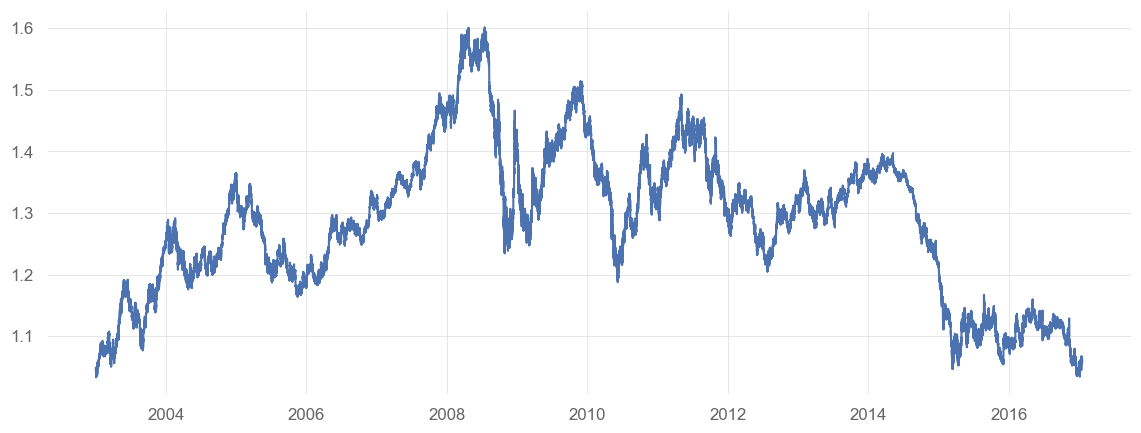

In [7]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_trn['<DT>'], target_prices_trn['<OPEN>'])

In [8]:
len(target_prices_trn)

492327

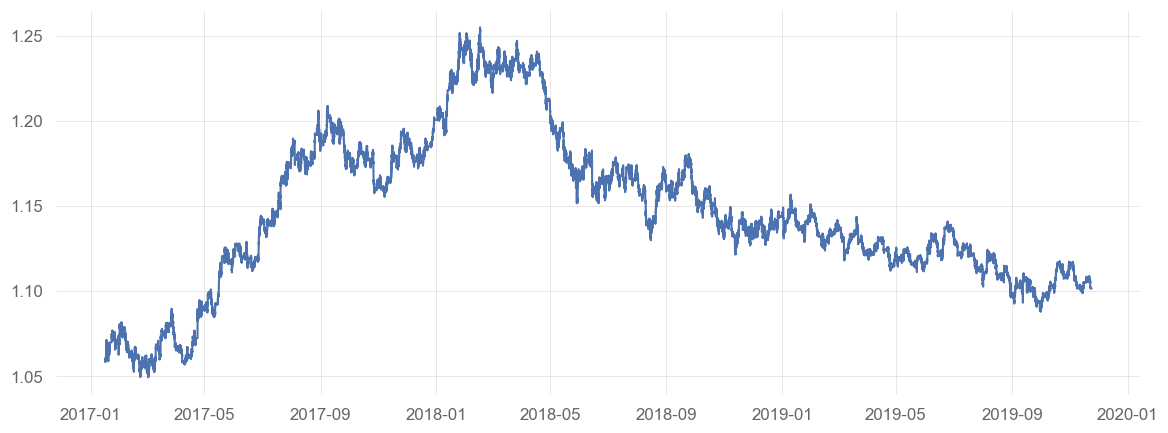

In [9]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_val['<DT>'], target_prices_val['<OPEN>'])

In [10]:
len(target_prices_val)

100000

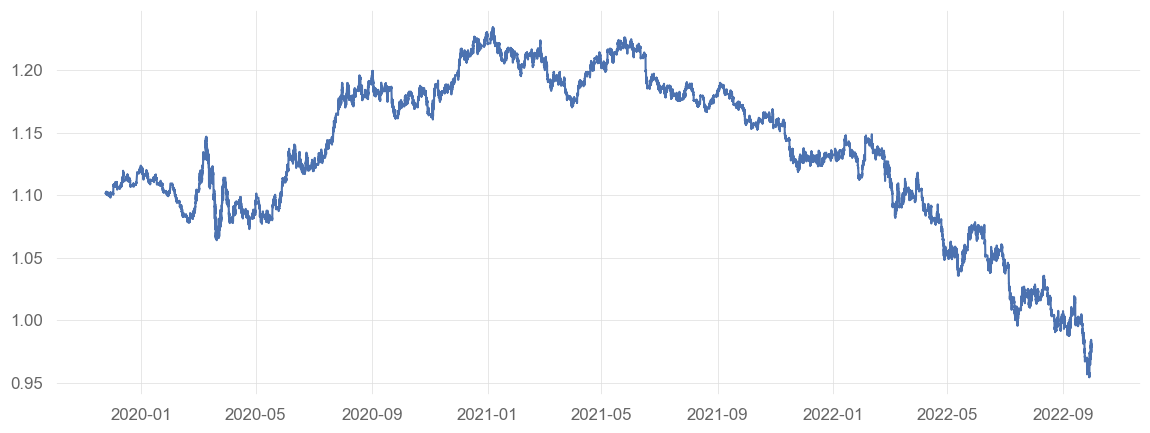

In [11]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_eval['<DT>'], target_prices_eval['<OPEN>'])

In [12]:
len(target_prices_eval)

100000

In [ ]:
basic_features = engineer_forex_features(forex_data, ForexFeEngStrategy.BASIC, {'recent_returns' : 8})

In [ ]:
basic_features_trn, basic_features_val, basic_features_eval = train_val_eval_split(
    basic_features,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

In [ ]:
basic_features

In [16]:
ta_target_features = engineer_forex_features({TARGET : forex_data[TARGET]}, ForexFeEngStrategy.TA, {'lags' : 8})

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:748: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._dip[0] = pos.dropna()[0: self._window].sum()
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:760: FutureWarning: The behavior of `series[i:j]` with 

In [17]:
ta_target_features

,<DT>,<EURUSD BB HIGH INDICATOR>,<EURUSD BB LOW INDICATOR>,<EURUSD BB PERC BAND>,<EURUSD BB WIDTH BAND>,<EURUSD ATR>,<EURUSD MACD DIFF>,<EURUSD VORTEX DIFF>,<EURUSD +DIR>,<EURUSD -DIR>,...,<EURUSD STOCH RSI K LAG 7>,<EURUSD STOCH RSI K LAG 8>,<EURUSD UO LAG 1>,<EURUSD UO LAG 2>,<EURUSD UO LAG 3>,<EURUSD UO LAG 4>,<EURUSD UO LAG 5>,<EURUSD UO LAG 6>,<EURUSD UO LAG 7>,<EURUSD UO LAG 8>
0,2001-01-03 01:00:00,0.0,1.0,-0.039328,0.168259,0.000000,-0.000097,-0.689694,0.000000,0.000000,...,0.000000,0.000000,19.046267,30.768525,33.335541,28.570212,39.997616,33.326709,0.000000,50.000000
1,2001-01-03 01:15:00,0.0,0.0,0.245593,0.170031,0.000389,-0.000097,-0.457151,0.000000,0.000000,...,0.000000,0.000000,28.753244,19.046267,30.768525,33.335541,28.570212,39.997616,33.326709,0.000000
2,2001-01-03 01:30:00,0.0,0.0,0.665412,0.165373,0.000440,-0.000046,-0.068181,0.000000,0.000000,...,0.000000,0.000000,37.346276,28.753244,19.046267,30.768525,33.335541,28.570212,39.997616,33.326709
3,2001-01-03 01:45:00,0.0,0.0,0.596355,0.158859,0.000416,-0.000018,0.000000,0.000000,0.000000,...,0.000000,0.000000,45.853373,37.346276,28.753244,19.046267,30.768525,33.335541,28.570212,39.997616
4,2001-01-03 02:00:00,0.0,0.0,0.528814,0.152187,0.000404,-0.000005,-0.061223,0.000000,0.000000,...,0.000000,0.000000,47.403826,45.853373,37.346276,28.753244,19.046267,30.768525,33.335541,28.570212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762307,2022-09-30 17:45:00,0.0,0.0,0.733767,0.388758,0.001176,0.000115,0.300745,26.808933,18.382341,...,0.678206,0.673186,51.578261,55.735460,61.893209,62.740925,67.865551,67.333934,66.338221,56.665744
762308,2022-09-30 18:00:00,0.0,0.0,0.625541,0.390403,0.001128,0.000072,0.356585,25.741488,17.650415,...,0.766450,0.678206,54.026596,51.578261,55.735460,61.893209,62.740925,67.865551,67.333934,66.338221
762309,2022-09-30 18:15:00,0.0,0.0,0.850067,0.398155,0.001135,0.000095,0.350740,27.402533,16.441844,...,0.810133,0.766450,49.932724,54.026596,51.578261,55.735460,61.893209,62.740925,67.865551,67.333934
762310,2022-09-30 18:30:00,0.0,0.0,0.783564,0.408687,0.001042,0.000088,0.392000,27.069780,16.242188,...,0.890754,0.810133,55.856996,49.932724,54.026596,51.578261,55.735460,61.893209,62.740925,67.865551


In [18]:
ta_target_features_trn, ta_target_features_val, ta_target_features_eval = train_val_eval_split(
    ta_target_features,
    TRN_START_DATE,
    VAL_START_DATE,
    VAL_START_DATE,
    EVAL_START_DATE,
    EVAL_START_DATE,
    EVAL_END_DATE
)

In [19]:
extended_features_trn = pd.merge(basic_features_trn, ta_target_features_trn, on='<DT>')
extended_features_val = pd.merge(basic_features_val, ta_target_features_val, on='<DT>')
extended_features_eval = pd.merge(basic_features_eval, ta_target_features_eval, on='<DT>')

In [20]:
def create_eurusd_env(
    eval,
    target_prices_trn,
    target_prices_eval,
    features_trn,
    features_eval,
    env_kwargs,
    trn_wrappers={},
    eval_wrappers={}
):
    env = ForexEnvBasic(
        target_prices_trn,
        features_trn,
        **deepcopy(env_kwargs)
    )
    return TrnOrEvalForexWrapper(
        env,
        target_prices_val,
        features_eval,
        eval,
        trn_wrappers,
        eval_wrappers
    )

In [21]:
BASE_ENV_KWARGS = dict(
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001),
    include_in_obs = ['position']
)

### Training metrics: validation mean reward
ForexFullEURUSD-v3 / ForexFullEURUSD-v6
* 2 actions
* running normalization
* extended features
* no commission / small spread

In [35]:
model_metrics = {
    'DQN no commission' : 'v6_DQN_1',
    'DQN with commission' : 'v3_DQN_1',
    'A2C no commission' : 'v6_A2C_2',
    'A2C with commission' : 'v3_A2C_1',
    'PPO no commission' : 'v6_PPO_1',
    'PPO with commission' : 'v3_PPO_2',
    'Tuned PPO no commission' : 'v6_PPO_2',
}

In [36]:
for model in model_metrics:
    model_metrics[model] =  pd.read_csv(
        f'{LOGS_PATH}/metrics snapshot/training_TensorBoard_ForexFullEURUSD-{model_metrics[model]}.csv'
    )

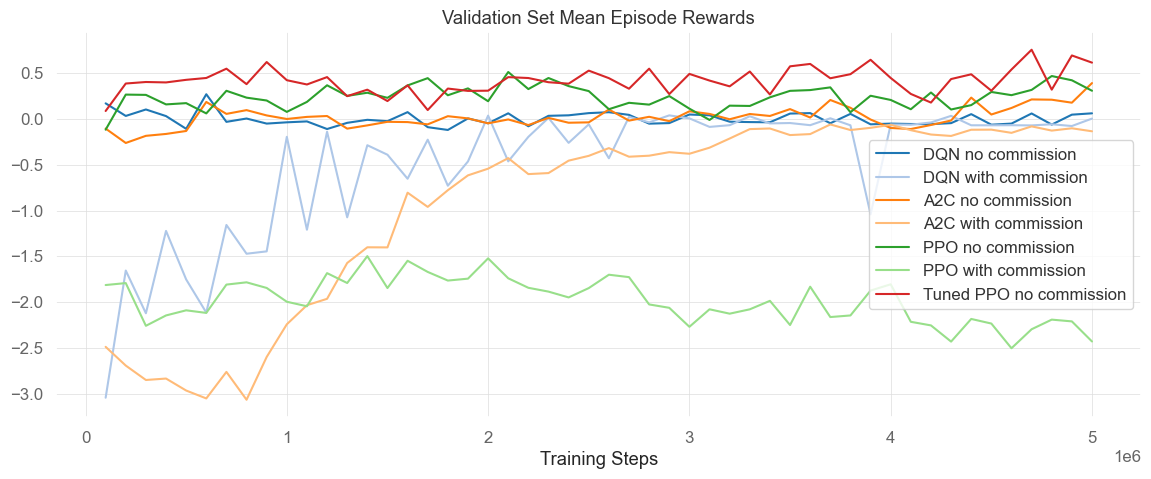

In [98]:
colors = plt.get_cmap('tab20',20).colors

fig = plt.figure(figsize=(14,5))

for i, model in enumerate(model_metrics):
    plt.plot(model_metrics[model]['Step'], model_metrics[model]['Value'], label=model, color=colors[i])

plt.xlabel('Training Steps')
plt.title('Validation Set Mean Episode Rewards')
plt.legend()
plt.show() 

### Tuned PPO Analysis
ForexFullEURUSD-v6
* 2 actions
* running normalization
* extended features
* no commission

In [47]:
def create_full_eurusd_env_v6(eval):
    return create_eurusd_env(
        eval,
        target_prices_trn,
        target_prices_val,
        extended_features_trn.drop('<DT>', axis=1),
        extended_features_val.drop('<DT>', axis=1),
        BASE_ENV_KWARGS | dict(trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0))
    )

In [48]:
register(
    'ForexFullEURUSD-v6',
    entry_point=create_full_eurusd_env_v6
)

In [84]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v6', load_best=True)

Loading latest experiment, id=4


In [85]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v6') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [86]:
best_model = PPO.load(best_model_path)

#### Validation set

In [50]:
portfolio_value_val_base = pd.Series(
    index=target_prices_val.iloc[:-2]['<DT>'].values,
    data=target_prices_val.iloc[:-2]['<CLOSE>'].values,
)

portfolio_value_val_base = portfolio_value_val_base.groupby(portfolio_value_val_base.index.date).agg('last')
portfolio_value_val_base.index = pd.to_datetime(portfolio_value_val_base.index)

In [52]:
returns_val_base = qs.utils.to_returns(portfolio_value_val_base)

In [87]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v6/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v6', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [88]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|██████████| 99998/99998 [00:29<00:00, 3343.19it/s]


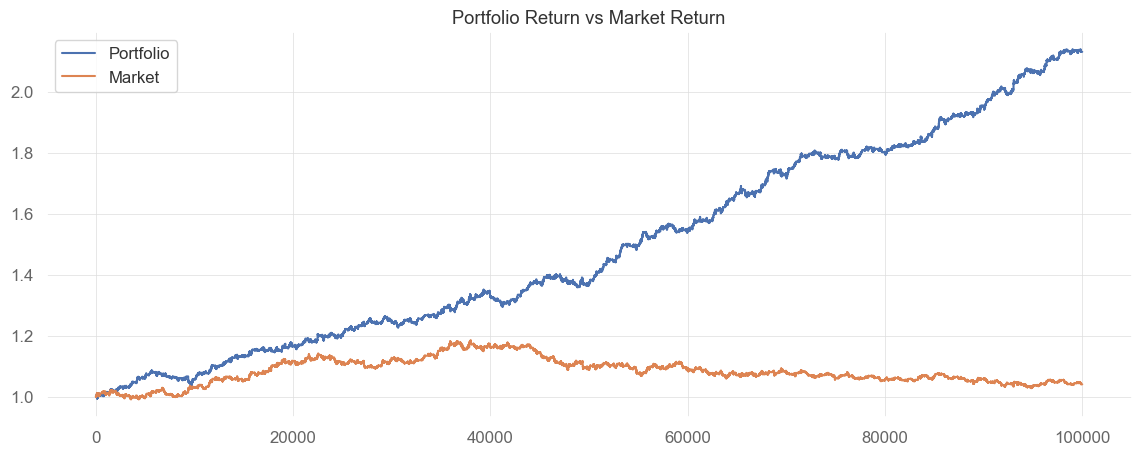

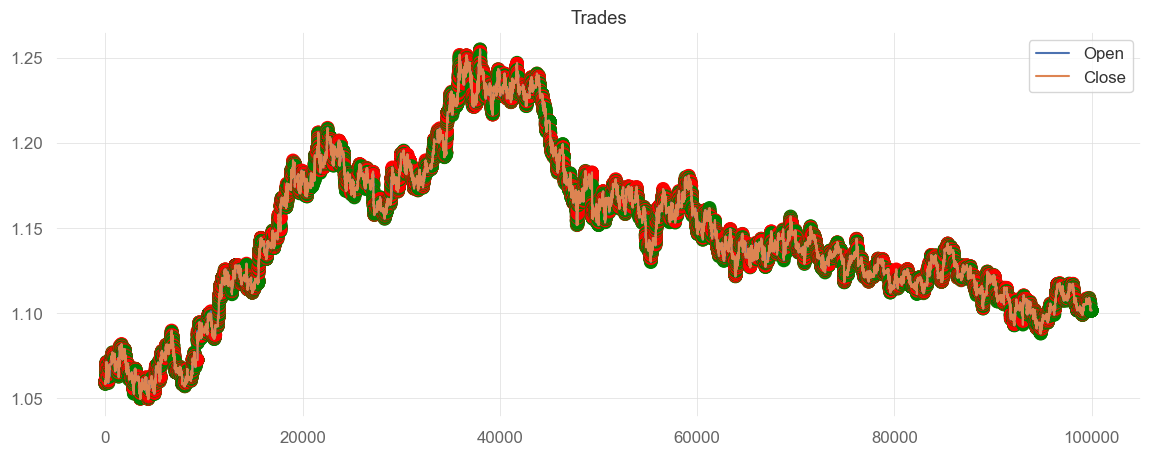

In [89]:
eurusd_env_val.render()

In [90]:
portfolio_value_val_ppo = pd.Series(
    index=target_prices_val.iloc[:-2]['<DT>'].values,
    data=eurusd_env_val.get_attr('history')[0]['portfolio_value'],
)

portfolio_value_val_ppo = portfolio_value_val_ppo.groupby(portfolio_value_val_ppo.index.date).agg('last')
portfolio_value_val_ppo.index = pd.to_datetime(portfolio_value_val_ppo.index)

In [91]:
returns_val_ppo = qs.utils.to_returns(portfolio_value_val_ppo)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-01-16  2017-01-16
End Period                 2019-11-24  2019-11-24
Risk-Free Rate             0.0%        0.0%
Time in Market             85.0%       85.0%

Cumulative Return          112.53%     3.95%
CAGR﹪                     30.22%      1.37%

Sharpe                     3.26        0.2
Prob. Sharpe Ratio         100.0%      65.49%
Smart Sharpe               3.18        0.19
Sortino                    5.77        0.28
Smart Sortino              5.62        0.28
Sortino/√2                 4.08        0.2
Smart Sortino/√2           3.98        0.19
Omega                      1.84        1.84

Max Drawdown               -4.06%      -12.86%
Longest DD Days            61          660
Volatility (ann.)          5.64%       5.57%
R^2                        0.0         0.0
Information Ratio          0.14        0.14
Calmar                     7.44        0.11
S

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-02,2018-03-21,2018-04-16,45,-4.061616,-3.910158
2,2017-03-16,2017-04-25,2017-05-16,61,-3.585004,-3.355104
3,2018-05-16,2018-06-08,2018-06-29,44,-2.817614,-2.586366
4,2017-11-19,2017-11-30,2017-12-27,38,-2.322960,-2.043556
5,2018-09-13,2018-10-02,2018-10-09,26,-1.618177,-1.501900


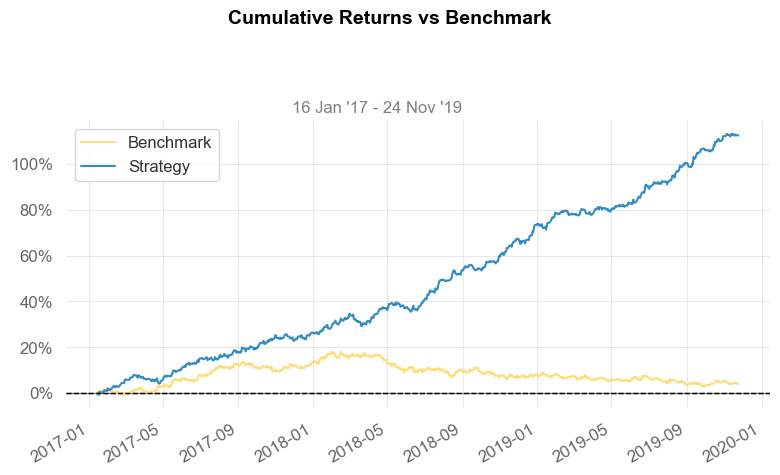

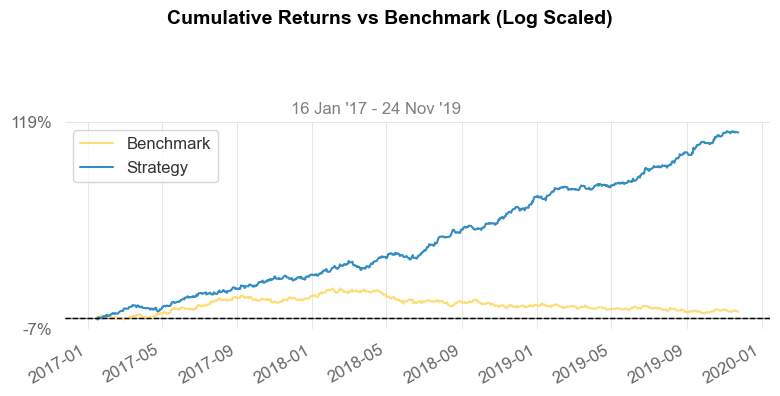

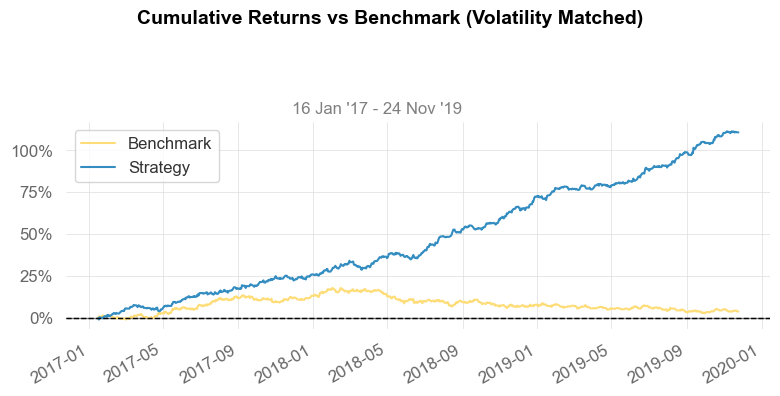

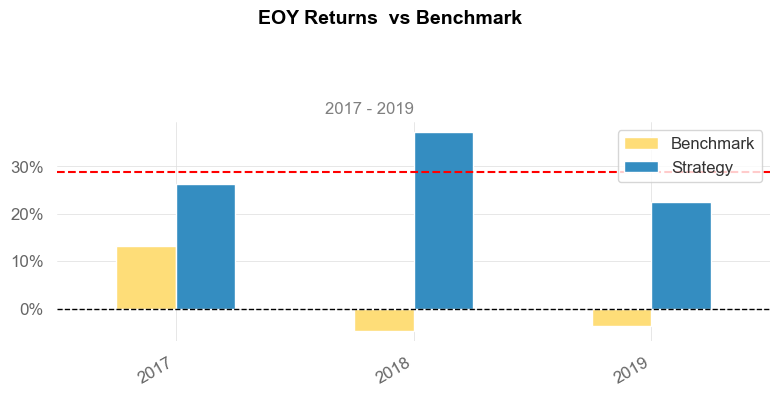

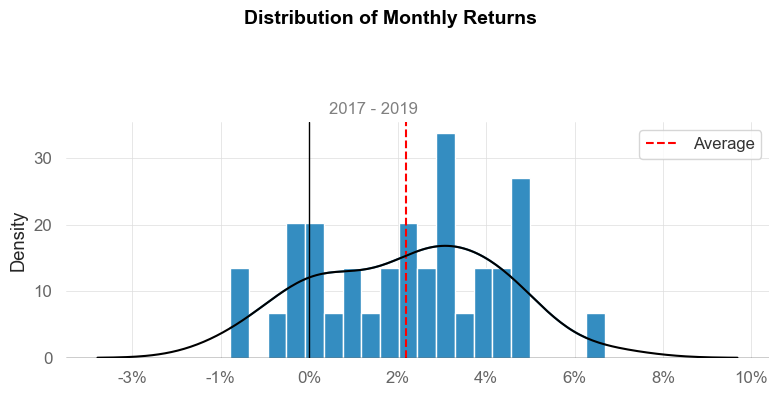

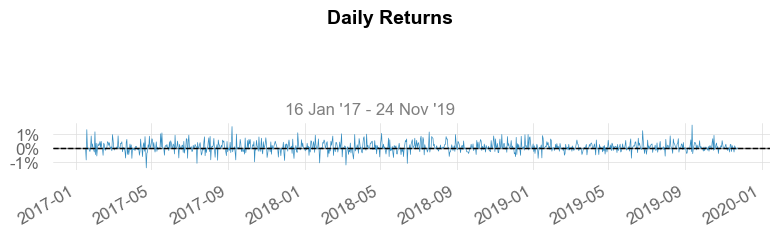

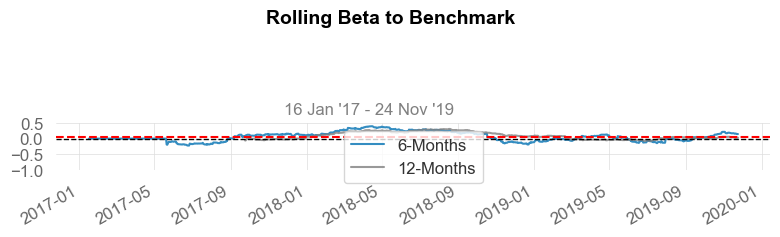

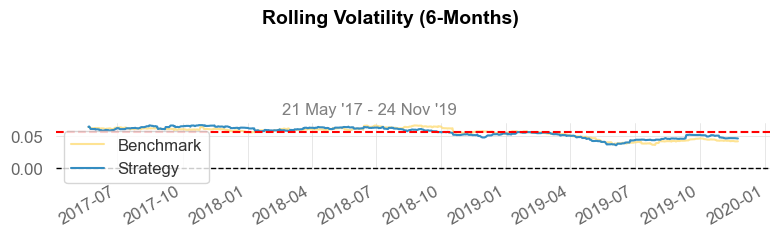

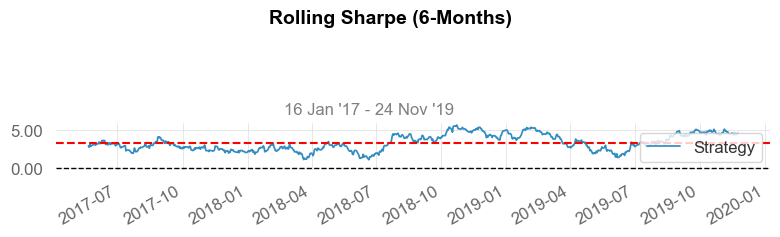

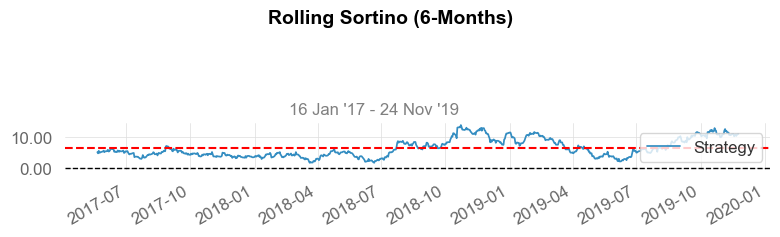

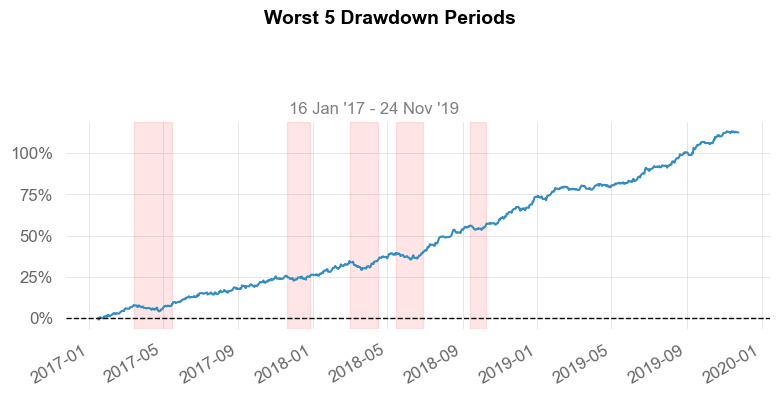

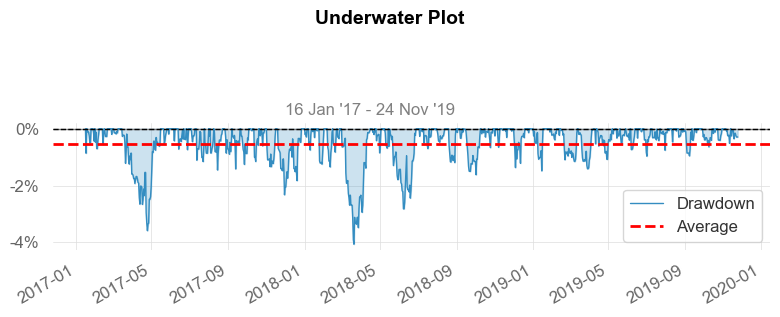

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


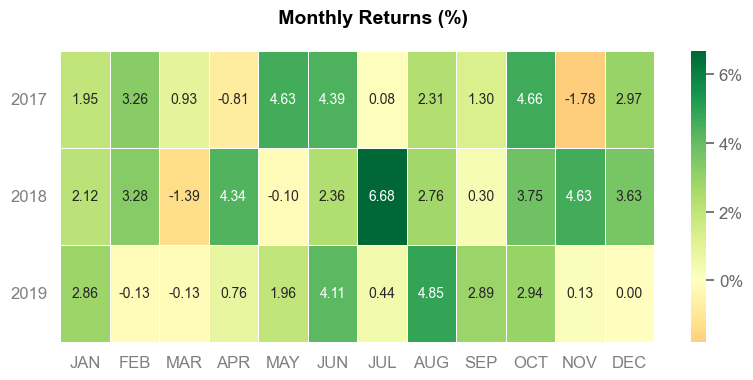

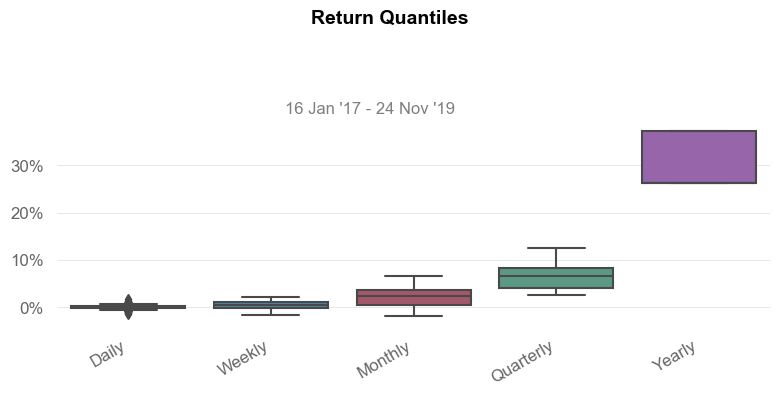

In [92]:
qs.reports.full(returns_val_ppo, returns_val_base)

#### Evaluation set

In [93]:
portfolio_value_eval_base = pd.Series(
    index=target_prices_eval.iloc[:-2]['<DT>'].values,
    data=target_prices_eval.iloc[:-2]['<CLOSE>'].values,
)

portfolio_value_eval_base = portfolio_value_eval_base.groupby(portfolio_value_eval_base.index.date).agg('last')
portfolio_value_eval_base.index = pd.to_datetime(portfolio_value_eval_base.index)

In [94]:
returns_eval_base = qs.utils.to_returns(portfolio_value_eval_base)

In [81]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v6/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=extended_features_eval.drop('<DT>', axis=1),
            **deepcopy(BASE_ENV_KWARGS | dict(trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0)))
        )
    )
)

In [82]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

  0%|          | 0/99998 [00:00<?, ?it/s]

100%|██████████| 99998/99998 [00:29<00:00, 3350.03it/s]


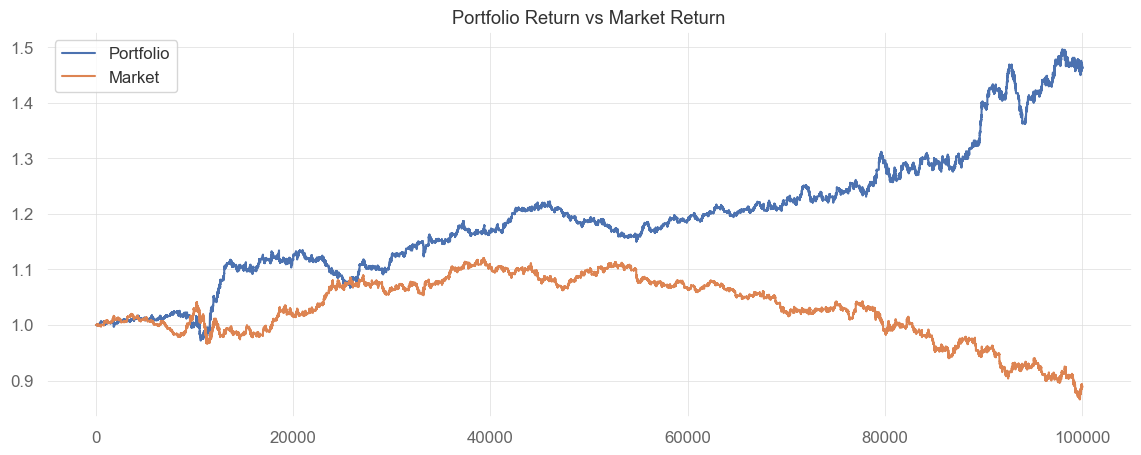

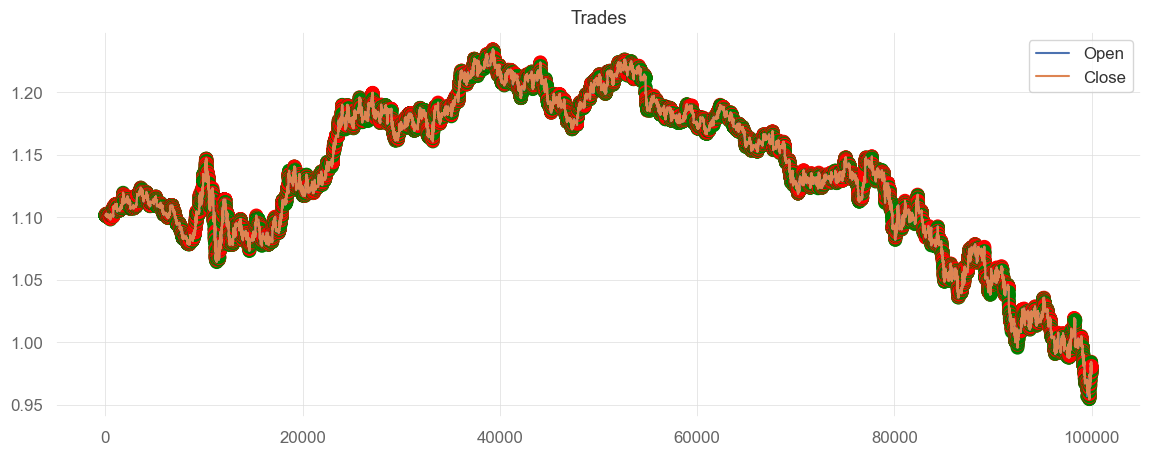

In [83]:
eurusd_env_eval.render()

In [95]:
portfolio_value_eval_ppo = pd.Series(
    index=target_prices_eval.iloc[:-2]['<DT>'].values,
    data=eurusd_env_eval.get_attr('history')[0]['portfolio_value'],
)

portfolio_value_eval_ppo = portfolio_value_eval_ppo.groupby(portfolio_value_eval_ppo.index.date).agg('last')
portfolio_value_eval_ppo.index = pd.to_datetime(portfolio_value_eval_ppo.index)

In [96]:
returns_eval_ppo = qs.utils.to_returns(portfolio_value_eval_ppo)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-11-24  2019-11-24
End Period                 2022-09-30  2022-09-30
Risk-Free Rate             0.0%        0.0%
Time in Market             86.0%       85.0%

Cumulative Return          46.31%      -11.02%
CAGR﹪                     14.27%      -4.01%

Sharpe                     1.49        -0.42
Prob. Sharpe Ratio         99.91%      19.46%
Smart Sharpe               1.3         -0.37
Sortino                    2.45        -0.57
Smart Sortino              2.12        -0.49
Sortino/√2                 1.73        -0.4
Smart Sortino/√2           1.5         -0.35
Omega                      1.34        1.34

Max Drawdown               -6.94%      -22.45%
Longest DD Days            220         631
Volatility (ann.)          6.31%       6.24%
R^2                        0.01        0.01
Information Ratio          0.09        0.09
Calmar                     2.06   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-07-18,2022-07-29,2022-09-01,45,-6.942920,-6.933885
2,2020-06-26,2020-08-18,2020-10-16,112,-5.454073,-5.213775
3,2021-03-16,2021-06-16,2021-10-22,220,-5.447936,-4.983803
4,2020-02-18,2020-03-19,2020-03-24,35,-4.832718,-4.771122
5,2022-03-03,2022-03-11,2022-05-22,80,-3.696103,-3.626431


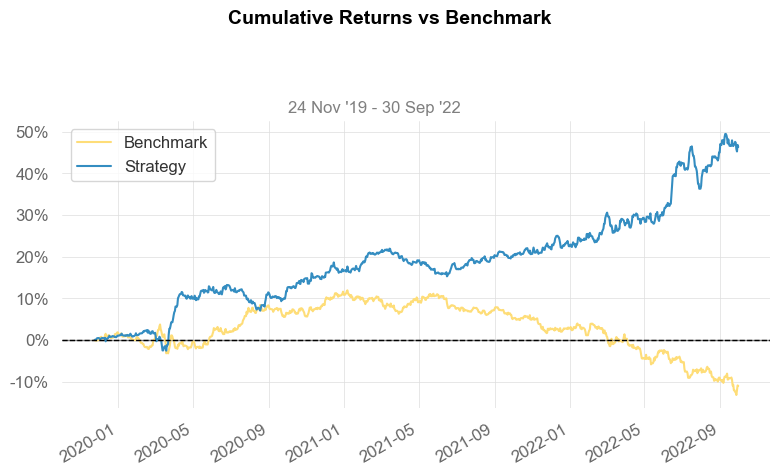

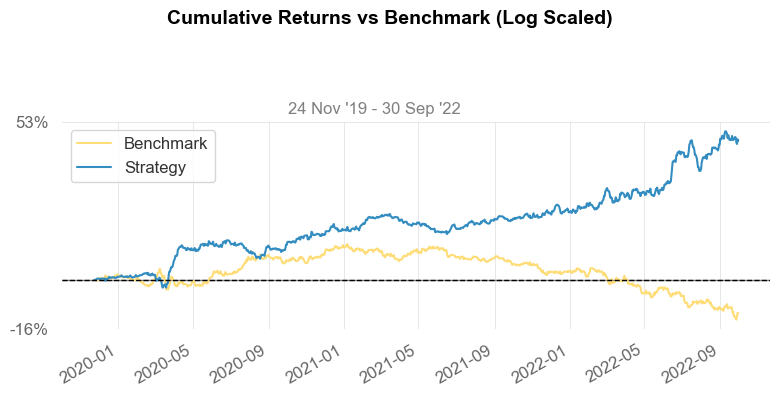

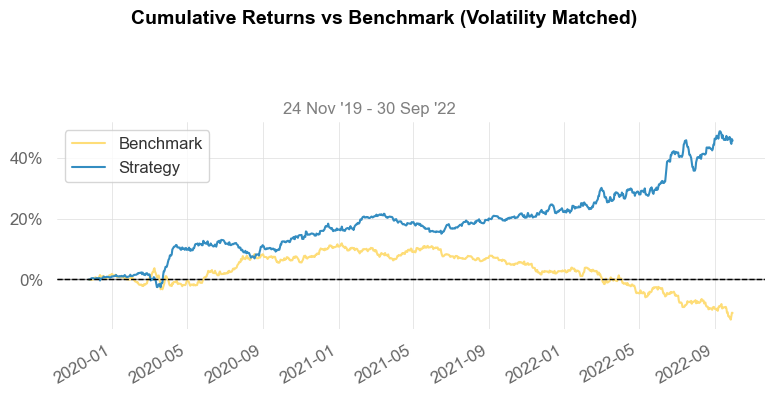

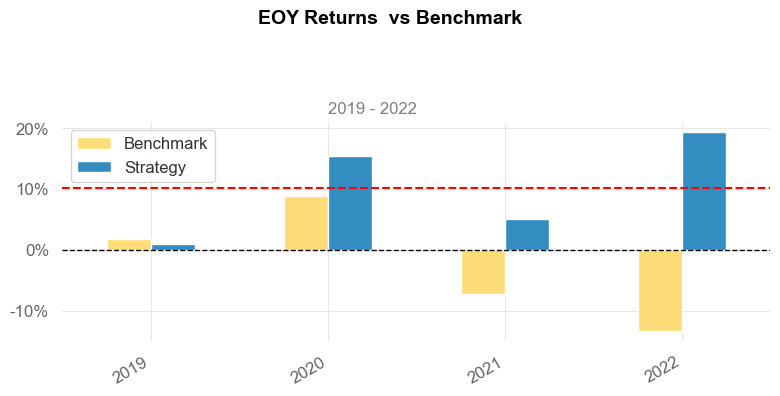

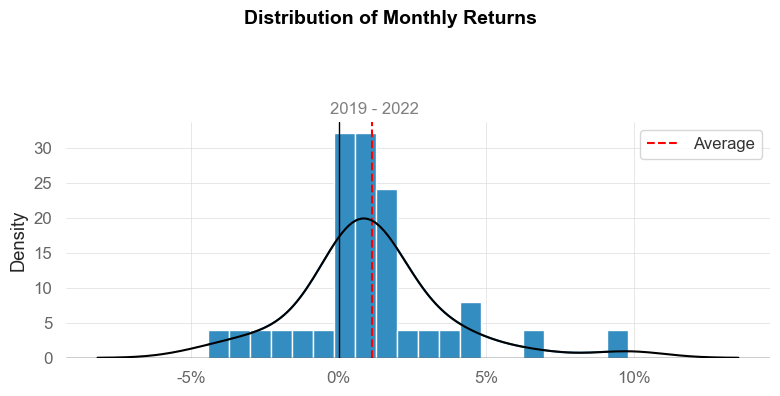

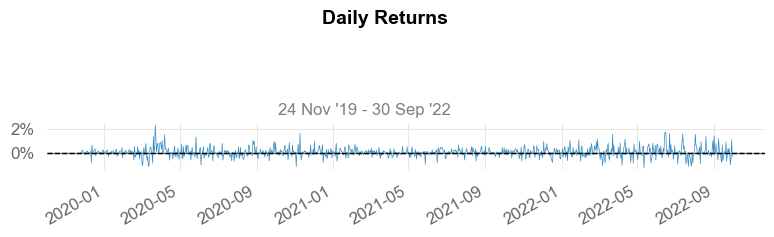

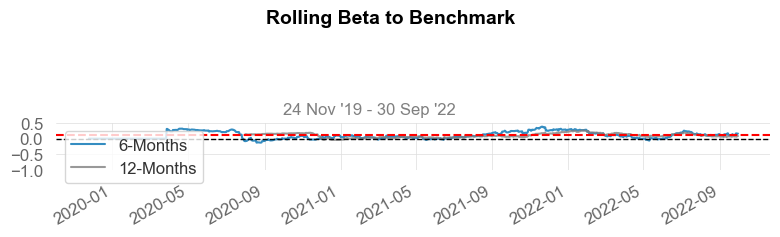

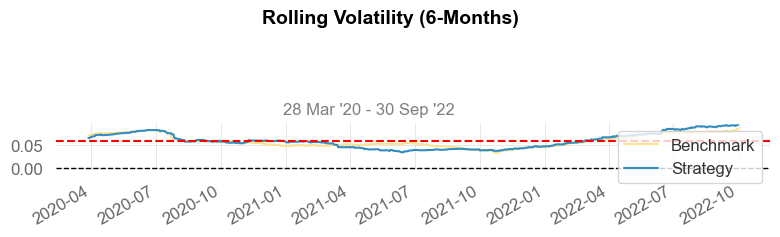

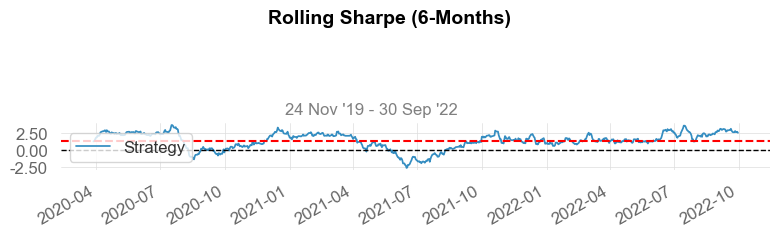

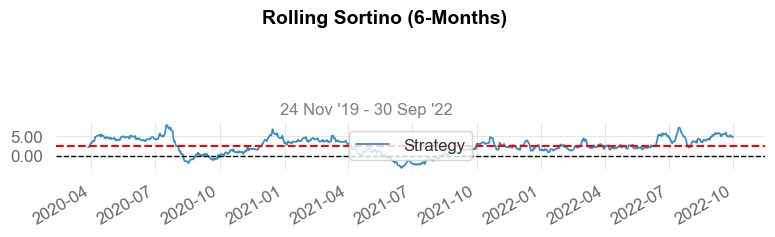

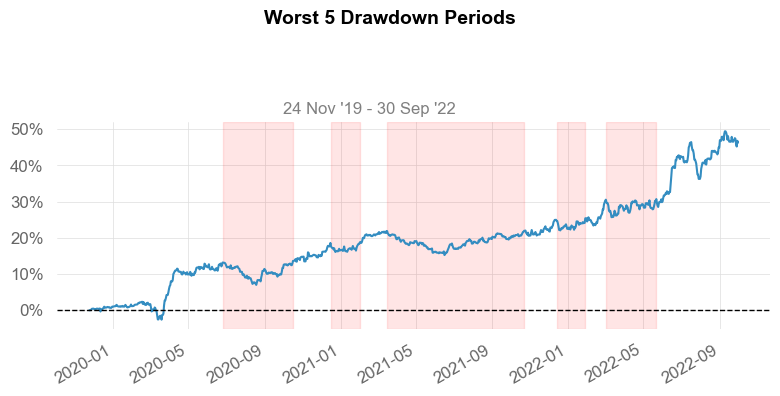

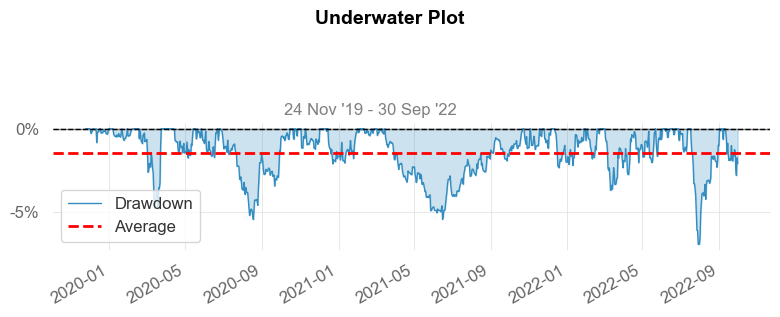

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


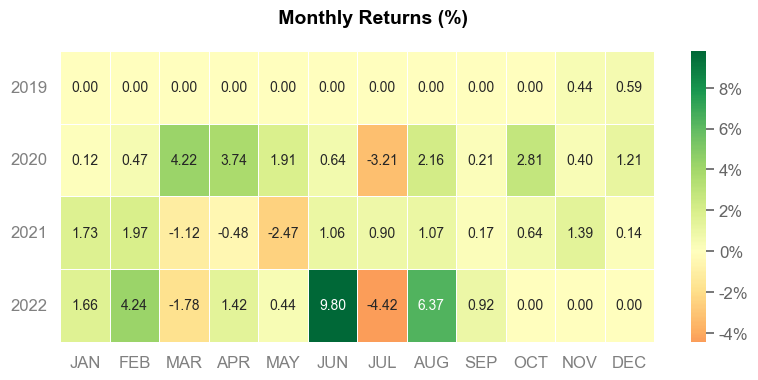

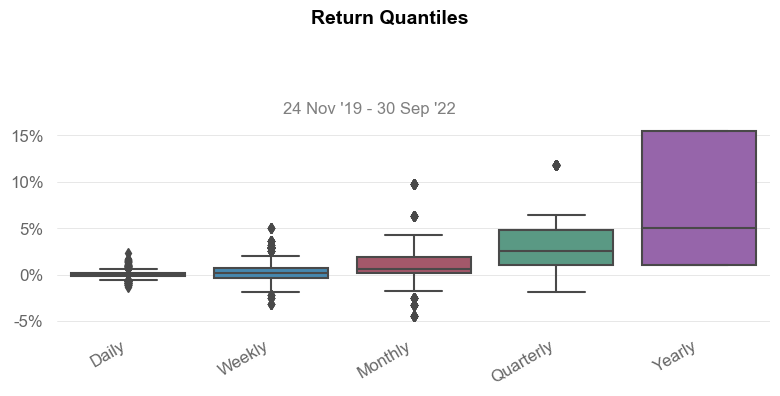

In [97]:
qs.reports.full(returns_eval_ppo, returns_eval_base)